In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from lmfit.models import GaussianModel

import image_analysis as ia # module with most of the code
import drop_detection_tools as ddt

from importlib import reload

reload(plt)
%matplotlib notebook

## Extract frames from video

This needs to be done only once for every video

In [5]:
path = './T-data/19-11/'
video_name = 'B-ol10-aq10-spf2.wmv'

ia.extract_frames(path, video_name)

Frames already extracted :)


## Get arrays from video

In [6]:
folder = './T-data/19-11/B-ol15-aq15-spf1'

spf = 1                    # seconds per frame in the video

color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color)

print(arrays.shape)


# spannometric estimation velocity of the droplets

#********************************************************
radius  = 0.3  # capillary radius [mm]
flux_ol = 15   # oil flux   [uL/min] = [mm3/min]
flux_aq = 15   # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]

print('v  = ', v,'\t[mm/s]')

Image.fromarray(mean_array).show()

(360, 960, 1280)
v  =  7.073553026306459 	[mm/s]


## Subtract the mean

In [7]:
arrays_sub = ia.subtract_mean(arrays,mean_array, negative=True)

m = -54.0, M = 53.0


In [8]:
# see an example

idx = 9

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

In [9]:
# see the corresponding negative image

neg = 255 - arrays_sub[idx]
Image.fromarray(neg).show()

## Rotation and gaussian filter

In [10]:
# test on one image

rotation = 37
filter_size = 0 # y and x sigmas for the filter

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

In [11]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:01<00:00, 181.95it/s]


## Channel analyzer

### Calibrate

In [12]:
c = ia.Channel_analyzer()

<IPython.core.display.Javascript object>


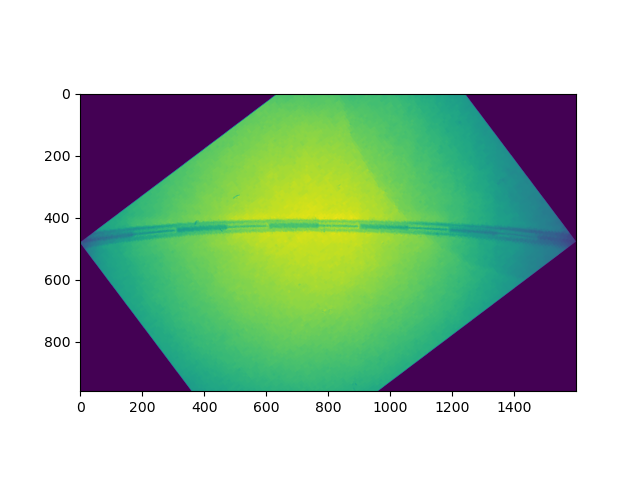

In [13]:
c.calibrate(calibr_img,15)

<IPython.core.display.Javascript object>


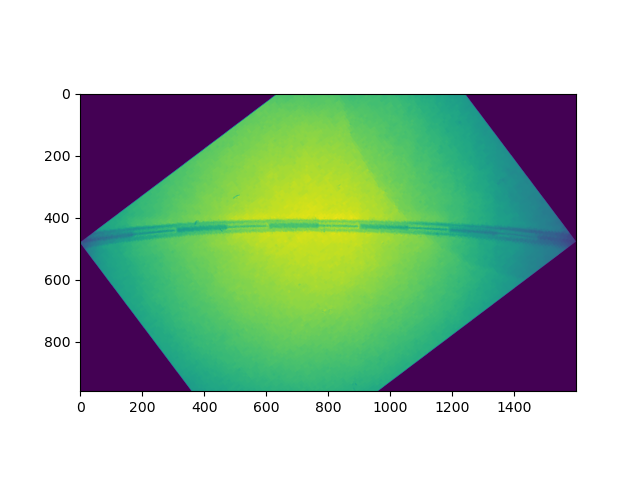

In [14]:
c.find_channel(calibr_img)

### Save calibration

In [27]:
c.save(name='calibr_B-ol15-aq15',folder='./T-data/19-11/')

### Load from existing calibration

In [15]:
c.load(name='calibr_B-ol15-aq15',folder='./T-data/19-11')

### Try waveform extraction on one image

<IPython.core.display.Javascript object>


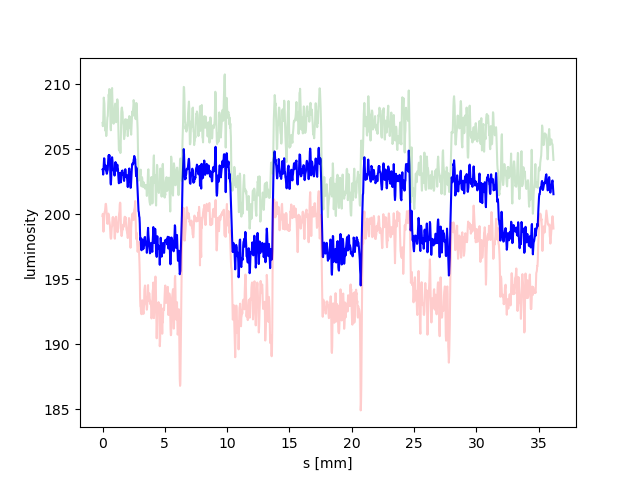

Text(0, 0.5, 'luminosity')

In [16]:
idx = 9

img = imgs[idx]
s, mean, std = c.evaluate(img)

plt.figure()
plt.plot(s,mean, color='blue')
plt.plot(s,mean - std,color='red',alpha=0.2)
plt.plot(s,mean + std,color='green',alpha=0.2)

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

## Extract the waveforms

In [156]:
s     = 0.
means = []
stds  = []

for idx in tqdm(range(len(imgs))):
    s, mean, std = c.evaluate(imgs[idx])
    means.append(mean)
    stds.append(std)

100%|██████████| 360/360 [00:26<00:00, 13.58it/s]


## Threshold searching and drop computing functions

In [26]:
# see drop_detection_tools

## Thresholds searching 

<Figure size 432x288 with 0 Axes>

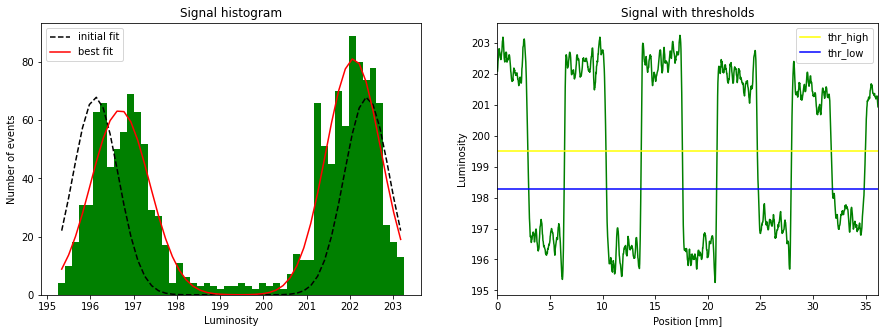

In [30]:
# Luminosity thresholds searching

#**************************************************
idx         = 9     # Frame index (checking plots)
nbins       = 50    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 4
low_sigmas = 2

# Not needed
# ymin      = 120   # Plot min. luminosity
# ymax      = 130   # Plot max. luminosity
#**************************************************

%matplotlib inline

# Plot one single signal (checking)
thr_low, thr_high = ddt.thr_searcher(Ydata=means[idx], nbins=nbins, plot_switch=plot_switch, Xdata=s,
                                     high_sigmas=high_sigmas, low_sigmas=low_sigmas)

### Compute thr for every image

Can produce errors

In [121]:
#for all images
thrs_low  = []    # thr_low array
thrs_high = []    # thr_high array

for mean in tqdm(means):
    thr_low, thr_high = ddt.thr_searcher(Xdata=s, Ydata=mean, nbins=nbins, plot_switch=False)
    thrs_low.append(thr_low)
    thrs_high.append(thr_high)

  1%|          | 4/360 [00:00<00:23, 15.02it/s]

  3%|▎         | 12/360 [00:00<00:21, 16.05it/s]

  5%|▌         | 18/360 [00:01<00:21, 15.59it/s]

  6%|▌         | 20/360 [00:01<00:22, 15.08it/s]

  7%|▋         | 24/360 [00:01<00:27, 12.14it/s]

  8%|▊         | 28/360 [00:01<00:24, 13.29it/s]

  9%|▉         | 32/360 [00:02<00:23, 13.96it/s]

 10%|█         | 36/360 [00:02<00:22, 14.28it/s]

 11%|█         | 40/360 [00:02<00:21, 15.12it/s]

 12%|█▏        | 44/360 [00:03<00:21, 15.01it/s]

 13%|█▎        | 46/360 [00:03<00:21, 14.60it/s]

 14%|█▍        | 50/360 [00:03<00:28, 10.89it/s]

 15%|█▌        | 54/360 [00:03<00:25, 12.00it/s]

 16%|█▌        | 58/360 [00:04<00:23, 13.13it/s]

 17%|█▋        | 60/360 [00:04<00:23, 12.76it/s]

 18%|█▊        | 64/360 [00:04<00:22, 13.32it/s]

 19%|█▉        | 70/360 [00:05<00:21, 13.61it/s]

 21%|██        | 74/360 [00:05<00:21, 13.49it/s]

 21%|██        | 76/360 [00:05<00:21, 13.17it/s]

 23%|██▎       | 82/360 [00:06<00:19, 14.23it/s]

 24%|██▍       | 88/360 [00:06<00:23, 11.61it/s]

 26%|██▌       | 92/360 [00:07<00:21, 12.41it/s]

 27%|██▋       | 98/360 [00:07<00:18, 14.44it/s]

 29%|██▉       | 104/360 [00:07<00:16, 15.82it/s]

 31%|███       | 110/360 [00:08<00:15, 16.52it/s]

 32%|███▏      | 114/360 [00:08<00:14, 16.75it/s]

 33%|███▎      | 120/360 [00:08<00:14, 16.89it/s]

 34%|███▍      | 124/360 [00:08<00:15, 15.55it/s]

 36%|███▌      | 130/360 [00:09<00:21, 10.90it/s]

 37%|███▋      | 134/360 [00:09<00:18, 12.36it/s]

 38%|███▊      | 138/360 [00:10<00:16, 13.44it/s]

 39%|███▉      | 142/360 [00:10<00:15, 14.51it/s]

 41%|████      | 146/360 [00:10<00:15, 14.06it/s]

 42%|████▏     | 152/360 [00:11<00:12, 16.13it/s]

 43%|████▎     | 156/360 [00:11<00:13, 15.67it/s]

 45%|████▌     | 162/360 [00:11<00:12, 16.21it/s]

 47%|████▋     | 168/360 [00:12<00:11, 16.45it/s]

 48%|████▊     | 172/360 [00:12<00:11, 16.57it/s]

 49%|████▉     | 178/360 [00:12<00:10, 16.70it/s]

 50%|█████     | 180/360 [00:12<00:10, 16.42it/s]

 51%|█████     | 184/360 [00:13<00:16, 10.53it/s]

 52%|█████▏    | 188/360 [00:13<00:13, 12.36it/s]

 53%|█████▎    | 192/360 [00:13<00:11, 14.33it/s]

 56%|█████▌    | 200/360 [00:14<00:09, 16.05it/s]

 57%|█████▋    | 204/360 [00:14<00:09, 16.36it/s]

 58%|█████▊    | 210/360 [00:14<00:08, 16.90it/s]

 59%|█████▉    | 214/360 [00:15<00:09, 16.02it/s]

 61%|██████    | 218/360 [00:15<00:08, 16.42it/s]

 61%|██████    | 220/360 [00:15<00:08, 16.97it/s]

 63%|██████▎   | 228/360 [00:16<00:08, 15.40it/s]

 64%|██████▍   | 232/360 [00:16<00:07, 16.07it/s]

 66%|██████▌   | 236/360 [00:16<00:08, 15.03it/s]

 67%|██████▋   | 240/360 [00:16<00:07, 15.08it/s]

 68%|██████▊   | 246/360 [00:17<00:07, 15.43it/s]

 69%|██████▉   | 248/360 [00:17<00:07, 15.03it/s]

 70%|███████   | 252/360 [00:18<00:11,  9.42it/s]

 71%|███████   | 256/360 [00:18<00:08, 11.79it/s]

 72%|███████▏  | 260/360 [00:18<00:07, 13.48it/s]

 73%|███████▎  | 264/360 [00:18<00:06, 14.38it/s]

 74%|███████▍  | 268/360 [00:19<00:05, 15.36it/s]

 76%|███████▌  | 272/360 [00:19<00:05, 15.43it/s]

 77%|███████▋  | 276/360 [00:19<00:05, 15.75it/s]

 78%|███████▊  | 282/360 [00:19<00:04, 15.60it/s]

 80%|████████  | 288/360 [00:20<00:04, 16.96it/s]

 81%|████████  | 292/360 [00:20<00:04, 16.97it/s]

 83%|████████▎ | 298/360 [00:20<00:03, 17.16it/s]

 84%|████████▍ | 302/360 [00:21<00:03, 15.76it/s]

 85%|████████▌ | 306/360 [00:21<00:03, 16.52it/s]

 86%|████████▌ | 310/360 [00:21<00:02, 16.90it/s]

 88%|████████▊ | 316/360 [00:21<00:02, 17.05it/s]

 89%|████████▉ | 320/360 [00:22<00:02, 17.35it/s]

 91%|█████████ | 326/360 [00:22<00:02, 16.96it/s]

 92%|█████████▏| 330/360 [00:22<00:01, 16.44it/s]

 93%|█████████▎| 334/360 [00:23<00:02,  9.14it/s]

 94%|█████████▍| 340/360 [00:23<00:01, 13.12it/s]

 96%|█████████▌| 344/360 [00:24<00:01, 14.71it/s]

 97%|█████████▋| 350/360 [00:24<00:00, 15.98it/s]

 98%|█████████▊| 354/360 [00:24<00:00, 15.41it/s]

 99%|█████████▉| 358/360 [00:24<00:00, 16.21it/s]

100%|██████████| 360/360 [00:25<00:00, 14.32it/s]

In [29]:
print(f'thrs_low: \t mean = {np.mean(thrs_low)}  \t std = {np.std(thrs_low,ddof=1)}')
print(f'thrs_high:\t mean = {np.mean(thrs_high)} \t std = {np.std(thrs_high,ddof=1)}')

thrs_low: 	 mean = 122.18641036257678  	 std = 0.2538114366186062
thrs_high:	 mean = 123.10704569730733 	 std = 1.6956861158985166


### Compute the thresholds using all data at once

<IPython.core.display.Javascript object>


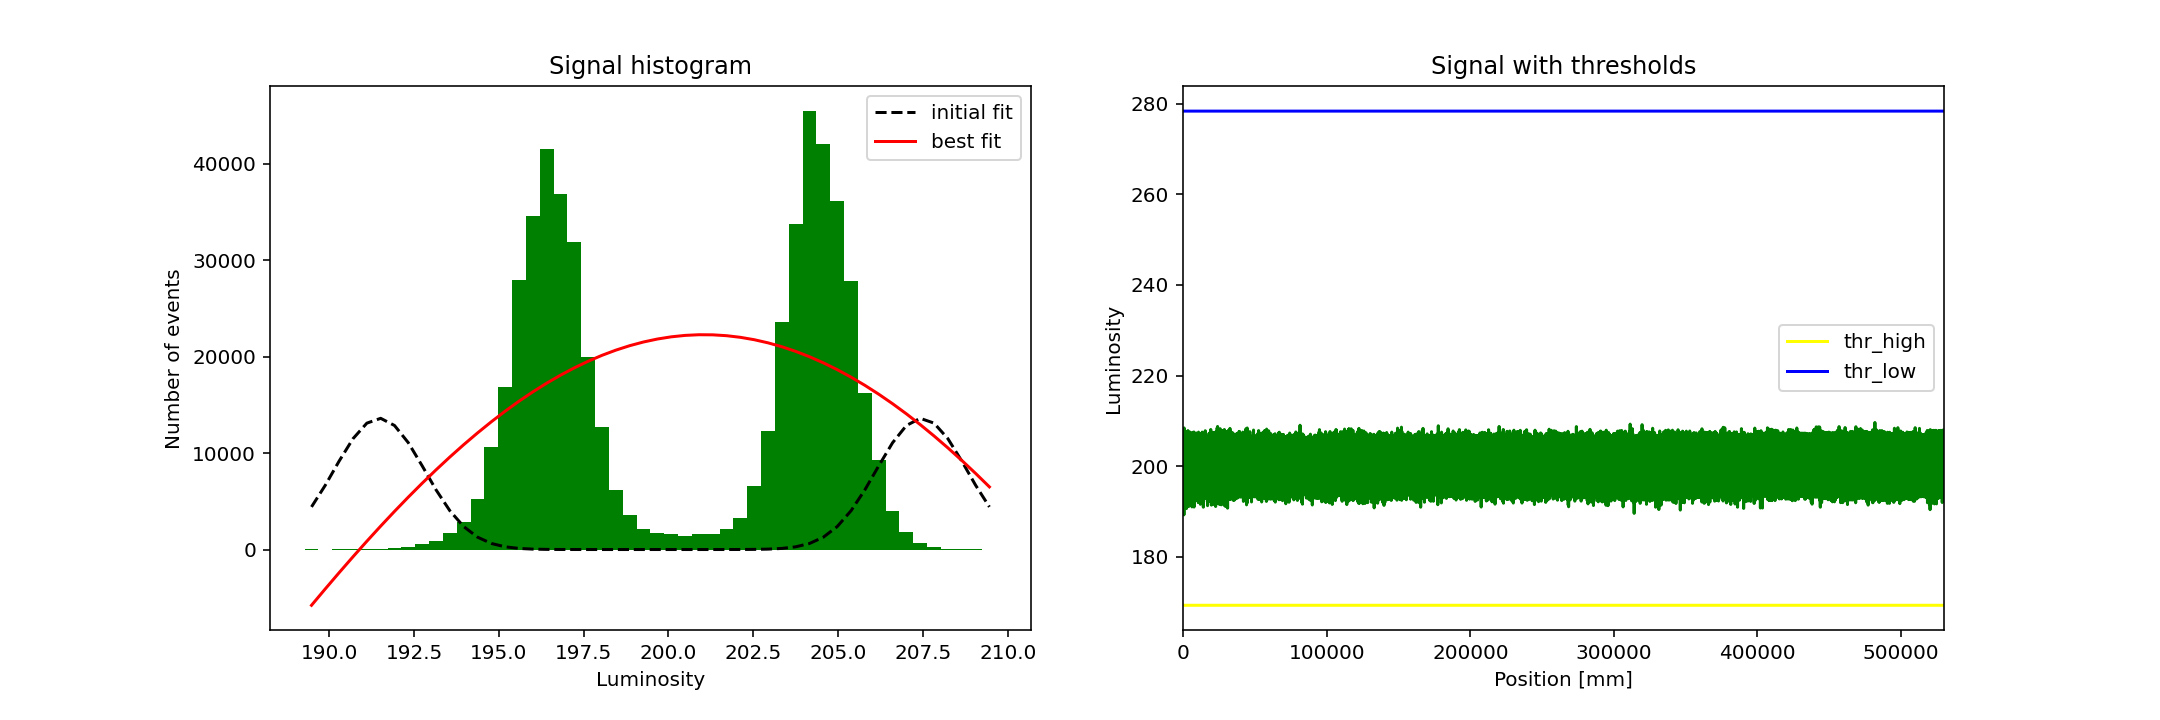

In [157]:
nbins       = 50    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 2
low_sigmas = 2

thr_low, thr_high = ddt.thr_searcher(Ydata=np.concatenate(means), nbins=nbins, plot_switch=plot_switch,
                                     high_sigmas=high_sigmas, low_sigmas=low_sigmas)

## Drop detection 

In [158]:
thr_low = thr_high = 200

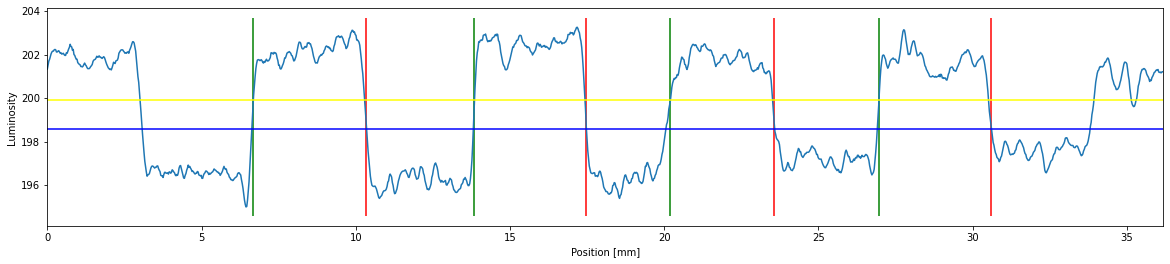

In [78]:
# Detection of the edges of the drops

#**************************************************
idx         = 37# Frame index (checking plot)
plot_switch = True  # Plots activation
# Not needed
# xrange    = 35    # Plot x max.
# ymin      = 120   # Plot min. luminosity 
# ymax      = 130   # Plot max luminosity 
#**************************************************

# Plot one single signal (checking)
%matplotlib inline
drop_start, drop_end = ddt.drop_det(Xdata=s, Ydata=means[idx],
                                    thr_low=thr_low, thr_high=thr_high, plot_switch=plot_switch)

### Compute starts and ends for every frame

In [159]:
#for all images
drop_starts = []    # drop_start array
drop_ends   = []    # drop_end array

for mean in means:
    drop_start, drop_end = ddt.drop_det(Xdata=s, Ydata=mean, thr_low=thr_low, thr_high=thr_high, plot_switch=False)
    drop_starts.append(drop_start)
    drop_ends.append(drop_end)

<IPython.core.display.Javascript object>


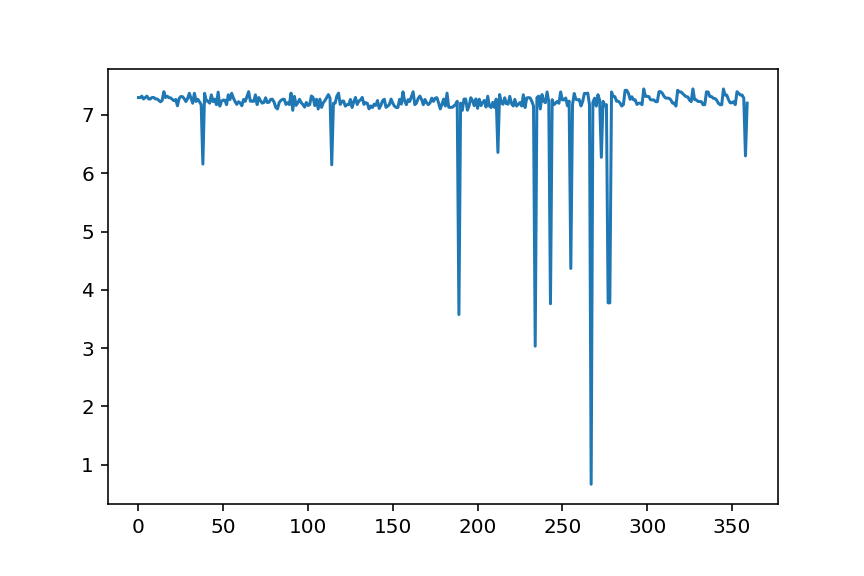

In [160]:
distances = [np.array(start[1:]) - np.array(start[:-1]) for start in drop_starts]


plt.figure()
plt.plot([d[0] for d in distances])

## Velocity computing 

### Simple velocity estimation

100%|██████████| 298/298 [00:00<00:00, 136437.35it/s]


Text(0, 0.5, 'Number of events')

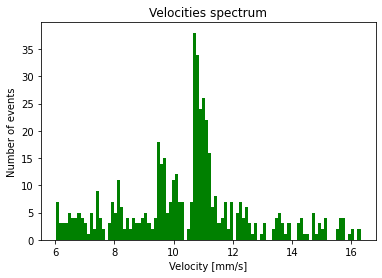

In [40]:
#******************************************************************************
imgs_switch = False        # Images activation

nbins       = 100          # Velocity histogram bins number
thr         = 6.           # Min. velocity acceptable [mm/s] 
vec         = drop_starts  # Velocity computed on 'drop_starts' or 'drop_ends'
#******************************************************************************

diffs = []

# iterate over frames
for idx in tqdm(range(len(vec) - 1)):
    delay_idx = -1
    exit = False
    diffs.append([])
    # iterate over droplets in a frame
    for i,drop in enumerate(vec[idx]):
        diff = 0.
        # look for the same droplet in the next frame
        while(diff < thr):
            delay_idx += 1
            try:
                diff = vec[idx + 1][delay_idx] - drop
            except(IndexError):
                exit = True
                break
        if exit:
            if len(diffs[-1]) == 1:
                if imgs_switch == True:
                    imgs[idx].show()
            break
        diffs[-1].append(diff)
        
velocities = np.concatenate(diffs)/spf
        
# Plot 
plt.figure()
plt.hist(velocities, bins = nbins, color='green')
plt.title('Velocities spectrum')
plt.xlabel('Velocity [mm/s]')
plt.ylabel('Number of events')

Text(0, 0.5, 'velocity [mm/s]')

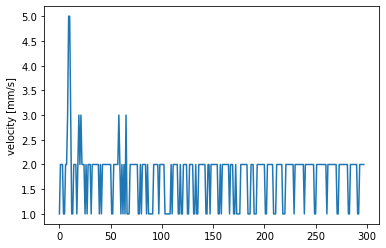

In [41]:
plt.figure()
plt.plot([len(diff) for diff in diffs])

plt.ylabel('velocity [mm/s]')

<Figure size 432x288 with 0 Axes>

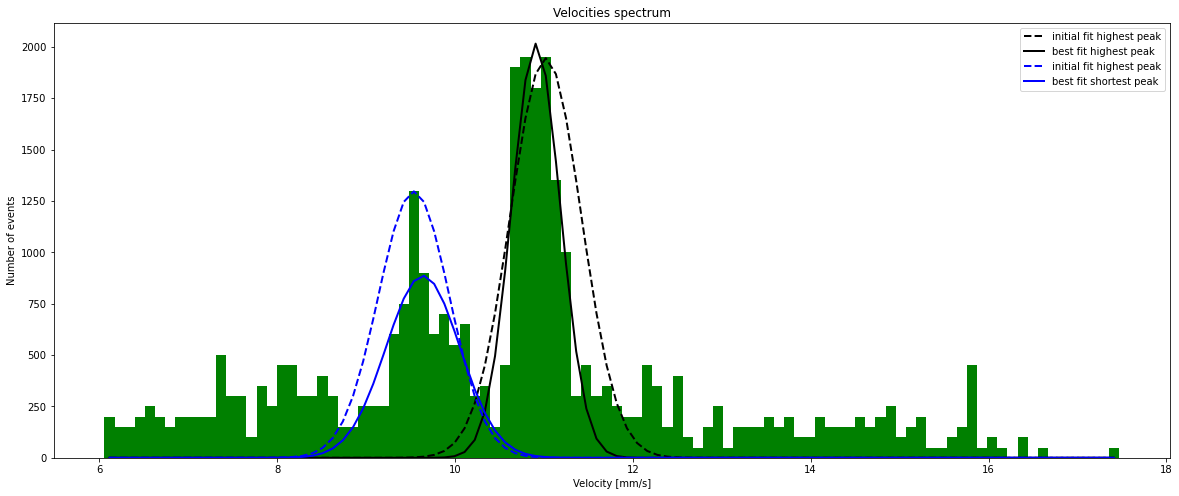

In [386]:
# Velocity fitting

#**************************************************
nbins = 100   # Histo bins number
k     = 2     
#**************************************************
  
# Histogram definition
freq,bins,p = plt.hist(velocities, nbins, color='green') 
x = 0.5 *(bins[:-1] + bins[1:]) 


# Fit highest peak ----------------------------------------------------------

# Max 1 finding
xmax1 = x[np.nonzero(freq==max(freq))]

# Fit
gauss1  = GaussianModel(prefix='g1_')
pars1   = gauss1.make_params(center=xmax1[1], sigma=0.4 , amplitude=max(freq))
result1 = gauss1.fit(freq, pars1, x=x)


# Fit lower peak -------------------------------------------------------------

# Max 2 finding
center1 = result1.best_values.get('g1_center')
sigma1  = result1.best_values.get('g1_sigma')
freq2   = freq 
i       = 0
while( i < len(freq)):
    if (x[i] > center1-k*sigma1) and (x[i] < center1+k*sigma1):
        freq2[i] = 0
    i = i+1
xmax2 = x[np.nonzero(freq2==max(freq2))]
    
# Fit    
gauss2  = GaussianModel(prefix='g2_')
pars2   = gauss2.make_params(center=xmax2[0], sigma=0.4 , amplitude=max(freq))
result2 = gauss2.fit(freq, pars2, x=x)


# Plot ------------------------------------------------------------------------

%matplotlib inline
plt.figure()
plt.figure(figsize=(20,8))
plt.hist(velocities, nbins, color='green')
plt.plot(x, result1.init_fit, 'k--', lw=2, label='initial fit highest peak')
plt.plot(x, result1.best_fit, 'k-', lw=2, label='best fit highest peak')
plt.plot(x, result2.init_fit, 'b--', lw=2, label='initial fit highest peak')
plt.plot(x, result2.best_fit, 'b-', lw=2, label='best fit shortest peak')
#plt.plot(x, freq2, color='yellow', label='exp. data for shortest peak fit')
plt.legend(loc='best')
plt.title("Velocities spectrum")
plt.xlabel("Velocity [mm/s]")
plt.ylabel("Number of events") 
plt.legend()


## Following the droplets along the video

A better alternative to Simple velocity estimation

In [161]:
# DO NOT TRANSFER TO .py file !!!! uses local variables

class Droplet():
    def __init__(self,ID):
        self.ID = ID
        self.frames = [] # frame IDs in which the droplet appears
        self.index_in_frame = [] # index of the droplet in every frame in which it appears
        
        self.starts = []
        self.ends = []
        
        self.sizes = None
        self.velocities = None
        
    @property
    def recurrence(self):
        return len(self.frames) # number of frames in which the droplet is visible
    
    @property
    def size(self):
        self.sizes = np.array(self.ends) - np.array(self.starts)
        return np.mean(self.sizes), np.std(self.sizes)
    
    @property
    def velocity(self):
        if len(self.frames) > 1:
            self.velocities = (np.array(self.starts[:-1]) - np.array(self.starts[1:]))/spf
            return np.mean(self.velocities), np.std(self.velocities)
        else:
            return np.nan, np.nan
        
    def add(self, frame_id, idx_in_frame, velocity_range=None, size_perc_tolerance=None):
        '''
        Tries to add a new frame to the droplet. Returns True if it manages to.
        '''
        start = drop_starts[frame_id][idx_in_frame]
        end = drop_ends[frame_id][idx_in_frame]
        
        if len(self.frames) > 0:
        
            # check if velocity is meaningful
            if velocity_range is not None:
                velocity = (self.starts[-1] - start)/spf
                if velocity < velocity_range[0]:
                    return False
                if velocity > velocity_range[1]:
                    return False

            # check if size is similar to the previous one
            if size_perc_tolerance is not None:
                old_size = self.ends[-1] - self.starts[-1]
                size = end - start
                if np.abs(size - old_size) > old_size*size_perc_tolerance:
                    return False
                
        self.frames.append(frame_id)
        self.index_in_frame.append(idx_in_frame)
        self.starts.append(start)
        self.ends.append(end)
        return True

100%|██████████| 359/359 [00:00<00:00, 14240.44it/s]


<IPython.core.display.Javascript object>


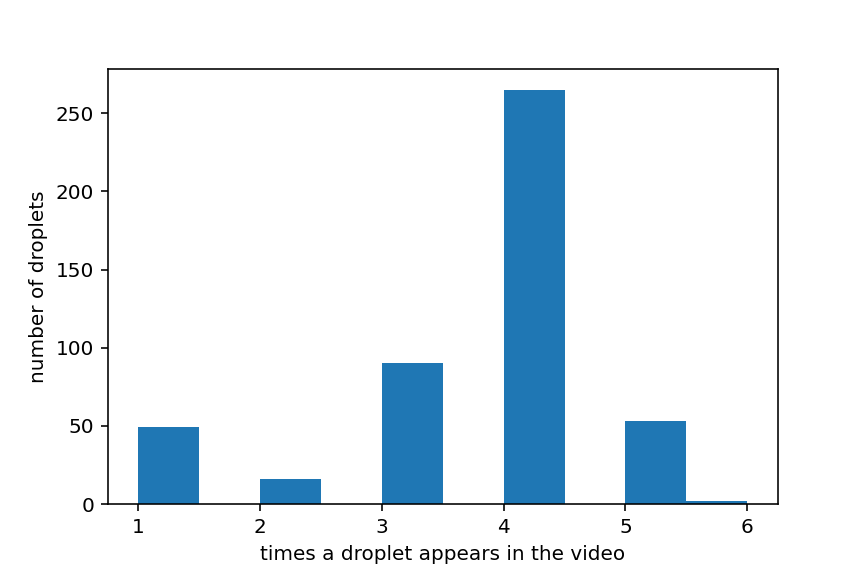

Text(0, 0.5, 'number of droplets')

In [162]:
velocity_range = [5., 15.]
size_perc_tolerance = 0.5


droplets = []
drop_idx = 0

# create ID mask
ID_mask = []
for drop_start in drop_starts:
    ID_mask.append([-1]*len(drop_start))

# iterate over frame
for idx in tqdm(range(len(drop_starts) - 1)):
    frame_idx = len(drop_starts) - 1 - idx # go reversed
    # iterate over droplets in a frame
    for i,start in enumerate(drop_starts[frame_idx]):
        # detect if droplet is already present
        drop_ID = ID_mask[frame_idx][i]
        if drop_ID == -1: # add new droplet
            ID_mask[frame_idx][i] = drop_ID = drop_idx
            droplets.append(Droplet(drop_idx))
            droplets[drop_idx].add(frame_idx,i)
            drop_idx += 1
        
        # now all droplets in this frame have a valid ID
        # we try to find them in the previous frame (remember we are looking the video in reverse)
        prev_frame_idx = frame_idx - 1
        for prev_i,prev_start in enumerate(drop_starts[prev_frame_idx]):
            if ID_mask[prev_frame_idx][prev_i] != -1: # droplet already assigned
                continue
            if droplets[drop_ID].add(prev_frame_idx,prev_i,
                                     velocity_range=velocity_range, size_perc_tolerance=size_perc_tolerance):
                ID_mask[prev_frame_idx][prev_i] = drop_ID # assign droplet
                break
                
droplets = np.array(droplets,dtype=Droplet)
                
def drops_in_frame(frame_idx):
    drop_ids = ID_mask[frame_idx]
    ddt.drop_det(Xdata=s, Ydata=means[frame_idx],
                                    thr_low=thr_low, thr_high=thr_high, plot_switch=True)
    for drop in droplets[drop_ids]:
        i = drop.frames.index(frame_idx)
        x = 0.5*(drop.starts[i] + drop.ends[i])
        y = 0.5*(thr_high + thr_low)
        plt.scatter(x,y,color='black',marker='^')
        plt.text(x,y + 0.25,drop.ID)
                
    return drop_ids


plt.figure()
plt.hist([d.recurrence for d in droplets])
plt.xlabel('times a droplet appears in the video')
plt.ylabel('number of droplets')

<IPython.core.display.Javascript object>


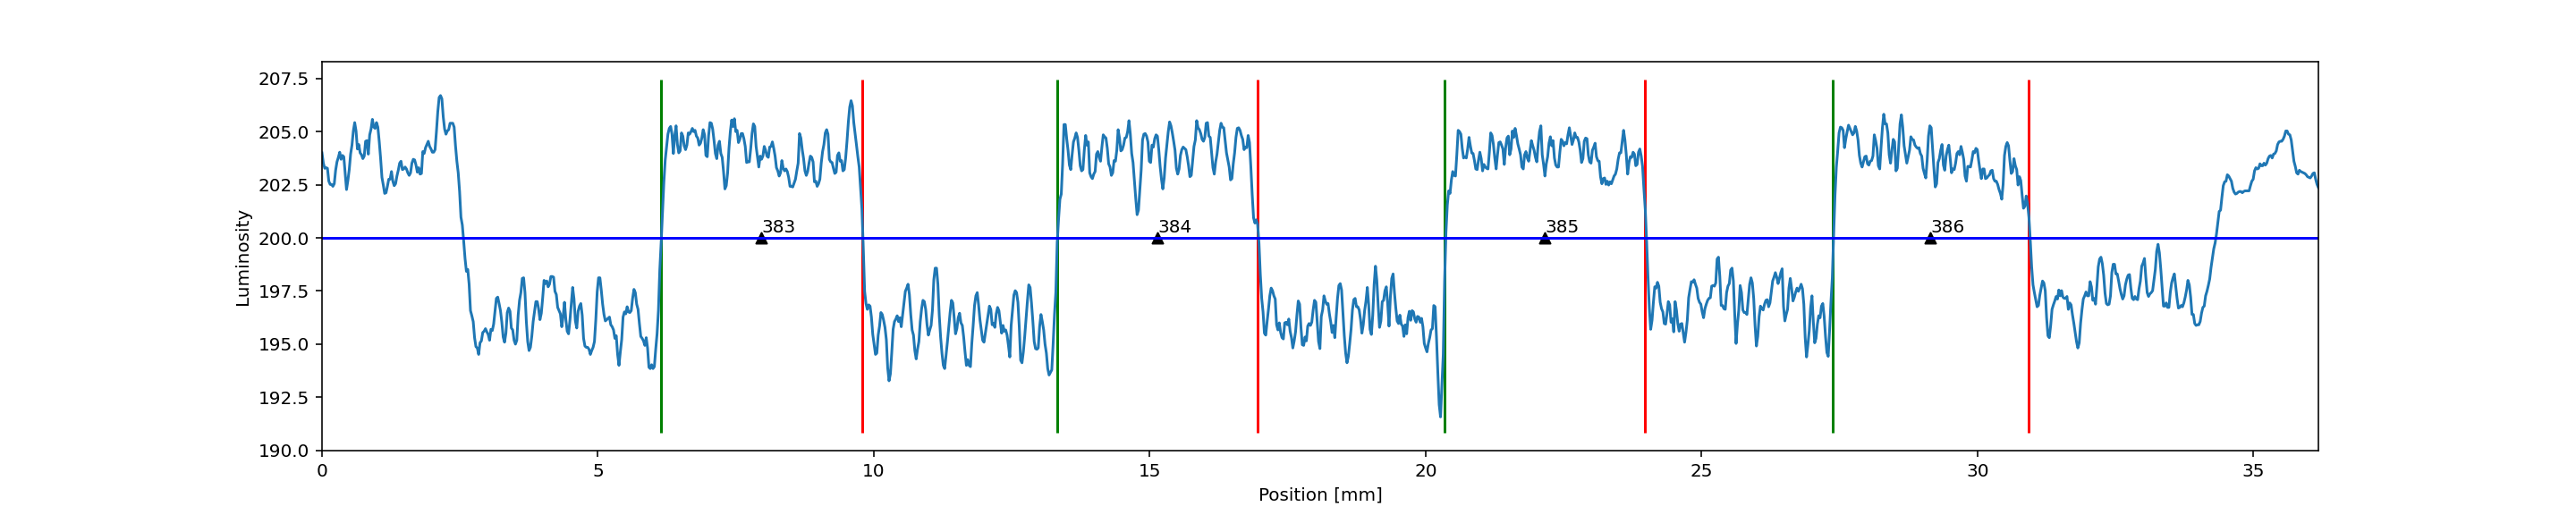

[383, 384, 385, 386]

In [163]:
# reload(plt)
%matplotlib notebook
idx = 70
drops_in_frame(idx)

<IPython.core.display.Javascript object>


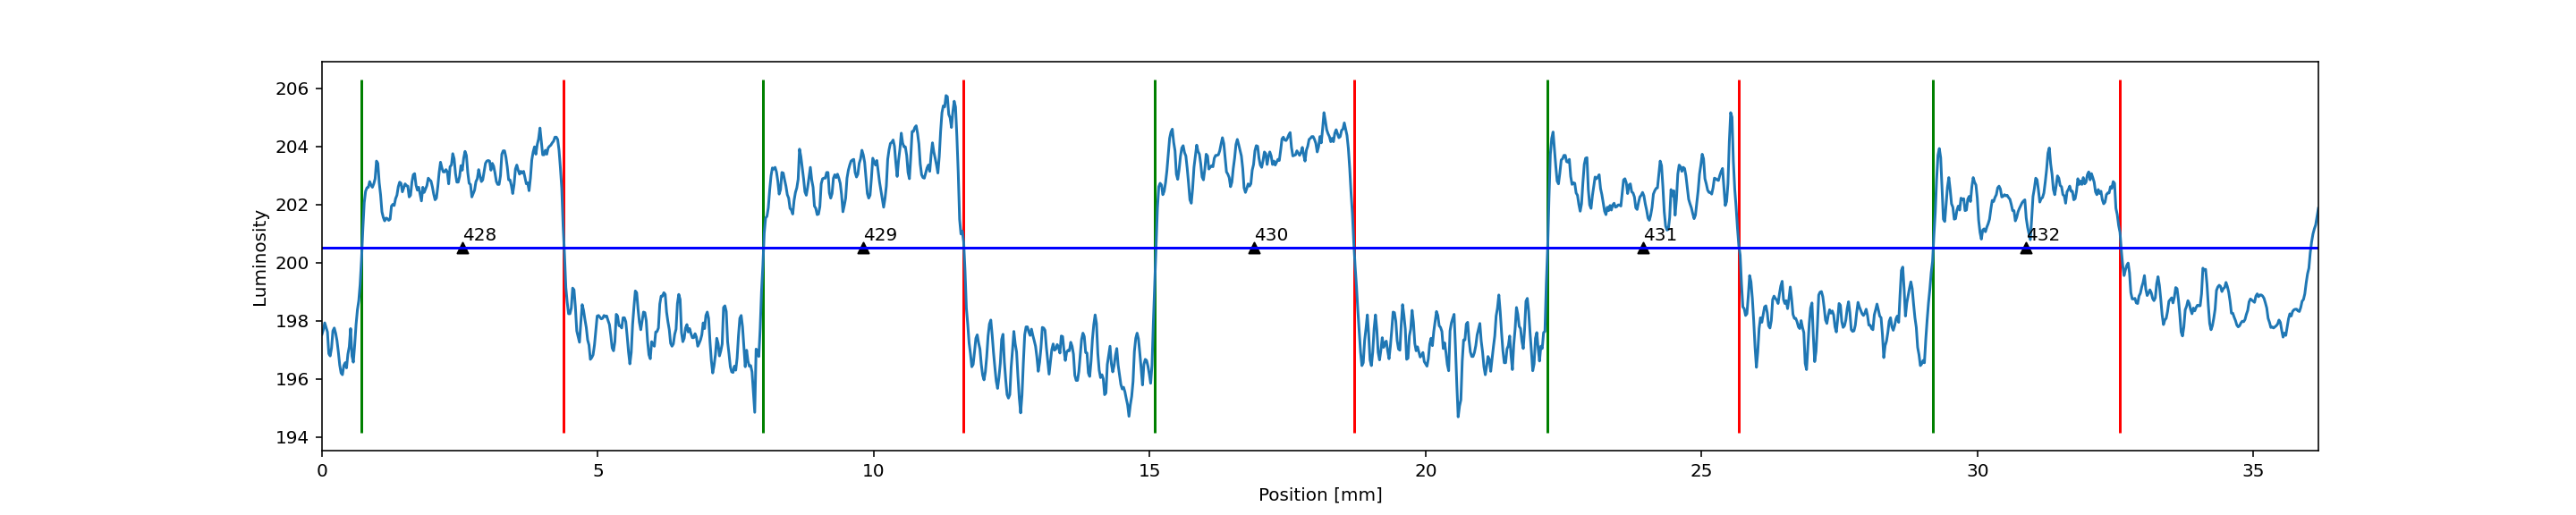

[428, 429, 430, 431, 432]

In [147]:
drops_in_frame(idx + 1)

<IPython.core.display.Javascript object>


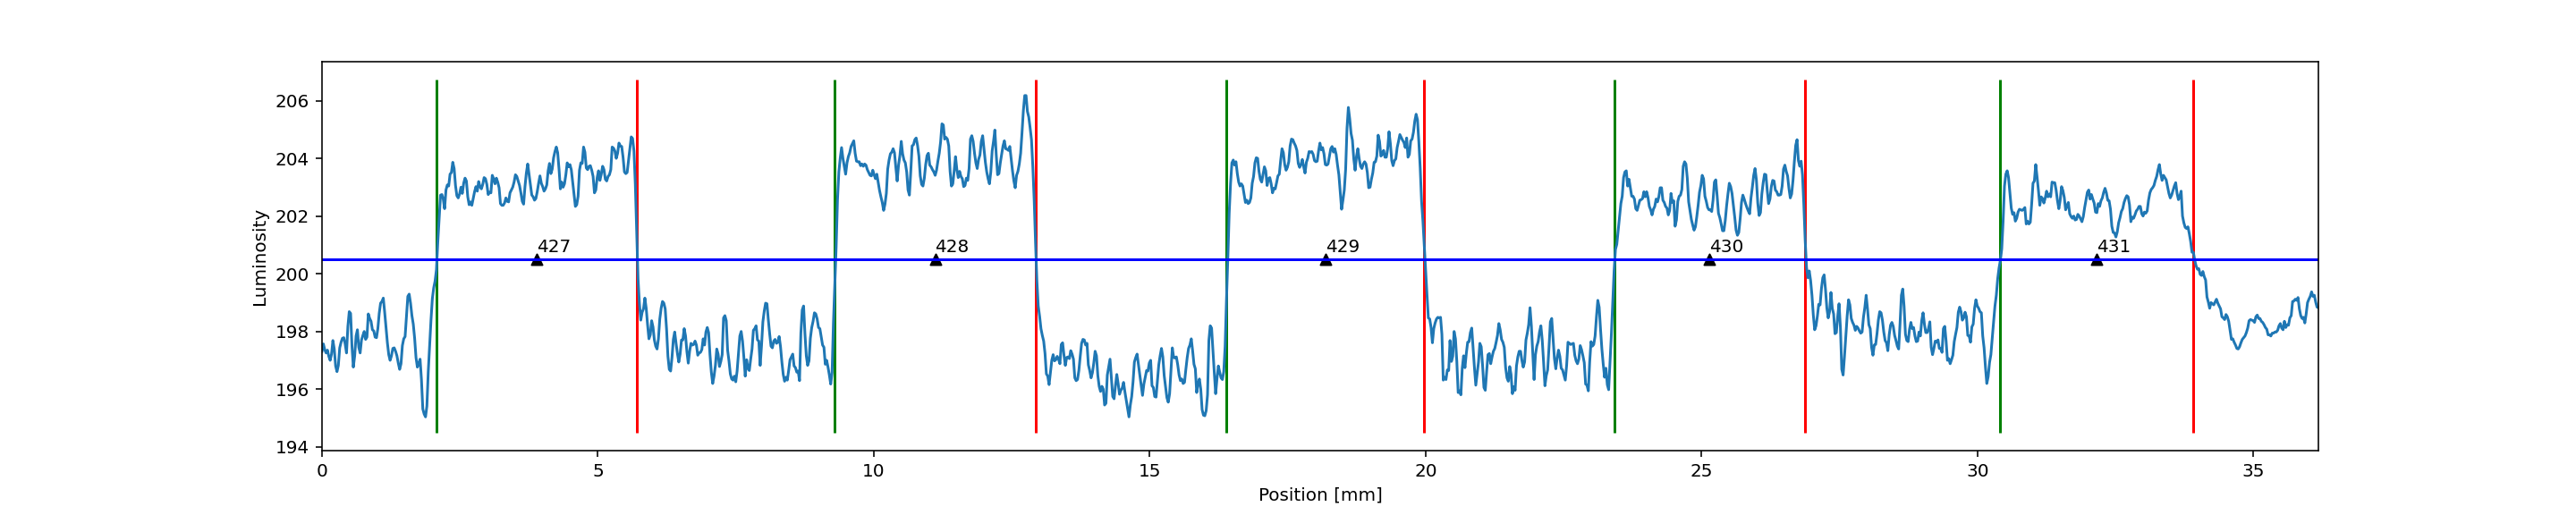

[427, 428, 429, 430, 431]

In [148]:
drops_in_frame(idx + 2)

In [57]:
droplets[671].frames

[52]

### Droplet statistics

In [42]:
q = np.sqrt(2*np.pi)

def gaus(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

# kernel density estimation
def kde_plot(xs, centers, sigmas, min_sigma=0.01,**kwargs):
    ys = np.zeros_like(xs)
    for i,x in tqdm(enumerate(xs)):
        for j,c in enumerate(centers):
            ys[i] += gaus(x,c,max(sigmas[j],min_sigma))
    
    # normalize
    ys /= np.sum(ys)
    
    xlabel = kwargs.pop('xlabel',None)
    plt.figure()
    plt.plot(xs,ys,**kwargs)
    plt.xlabel(xlabel)
    plt.ylabel('probability')
    plt.tight_layout()
    
    return ys

<IPython.core.display.Javascript object>


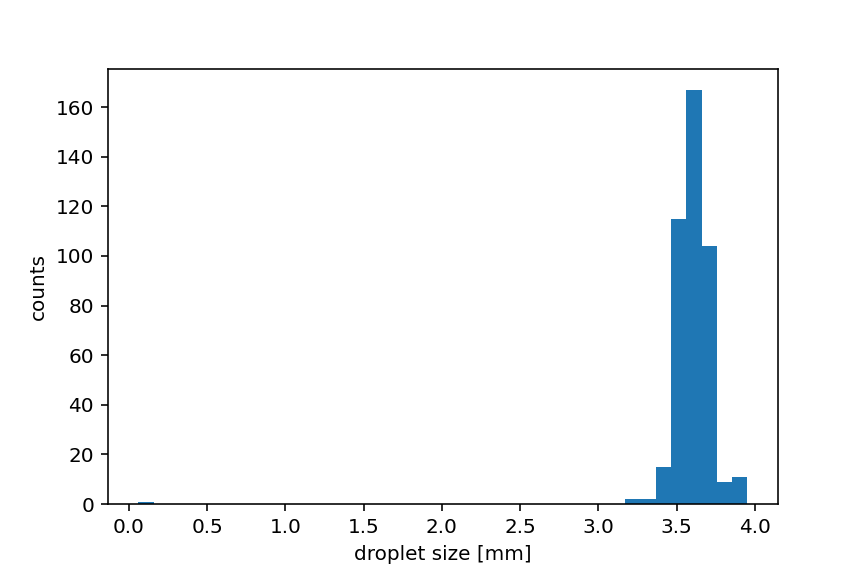

426


In [164]:
# size

min_recurrence = 2

size_means = [d.size[0] for d in droplets if d.recurrence >= min_recurrence]
size_stds = [d.size[1] for d in droplets if d.recurrence >= min_recurrence]


# histogram
plt.figure()
plt.hist(size_means,bins=40)
plt.xlabel('droplet size [mm]')
plt.ylabel('counts')

print(len(size_means))

10000it [00:09, 1046.92it/s]


<IPython.core.display.Javascript object>


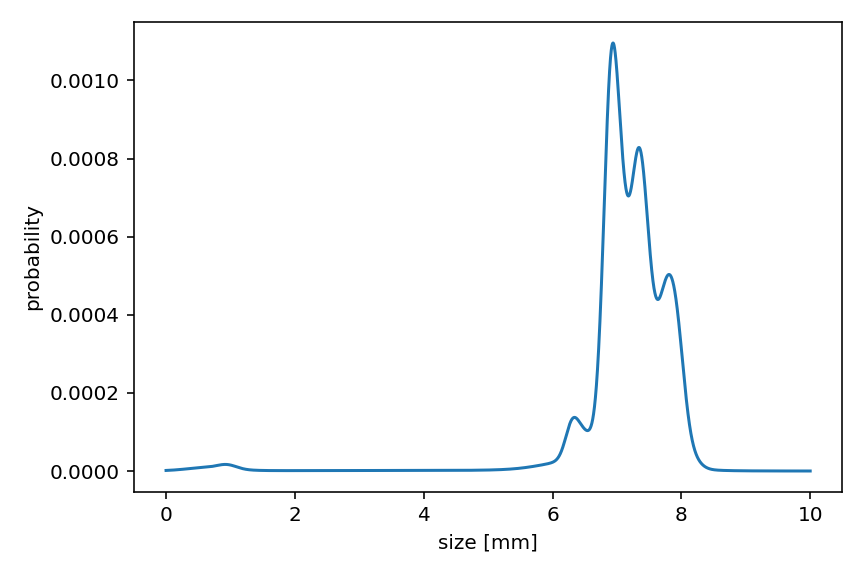

array([1.57720627e-06, 1.58429506e-06, 1.59141730e-06, ...,
       1.64932406e-07, 1.64797498e-07, 1.64662715e-07])

In [40]:
# kde plot

xs = np.linspace(0,10,10000)

kde_plot(xs, size_means, size_stds, min_sigma=0.1, xlabel='size [mm]')

<IPython.core.display.Javascript object>


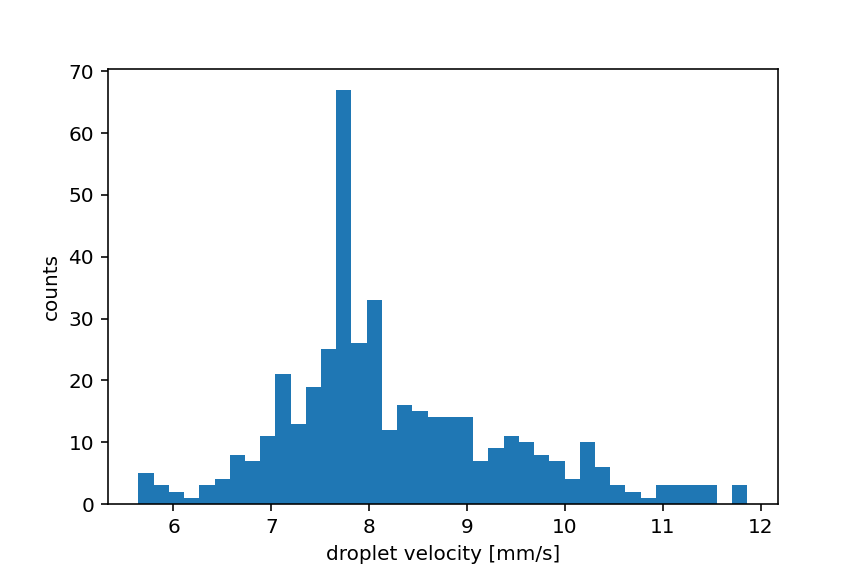

426


In [165]:
# velocity

# at least 2 otherwise cannot compute velocity
min_recurrence = 2

velocity_means = [d.velocity[0] for d in droplets if d.recurrence >= min_recurrence]
velocity_stds = [d.velocity[1] for d in droplets if d.recurrence >= min_recurrence]

# histogram
plt.figure()
plt.hist(velocity_means,bins=40)
plt.xlabel('droplet velocity [mm/s]')
plt.ylabel('counts')

print(len(velocity_means))

<IPython.core.display.Javascript object>


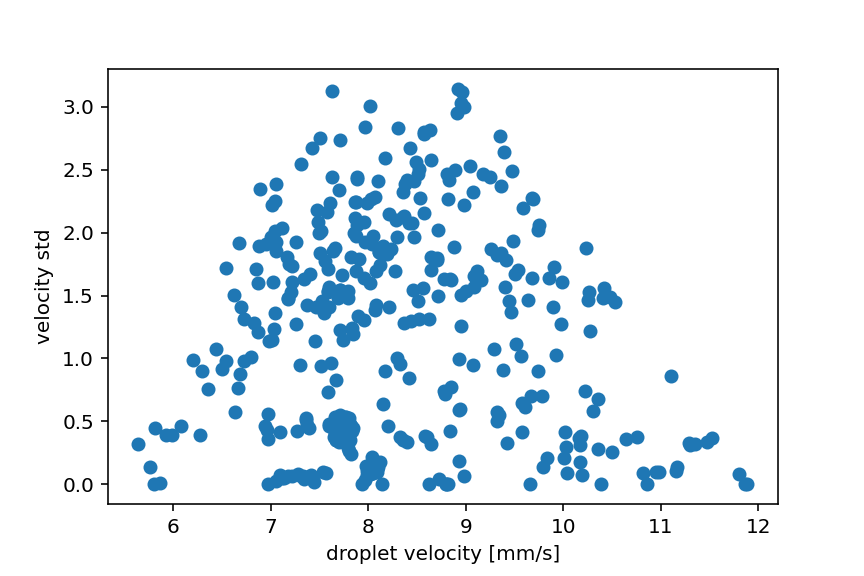

Text(0, 0.5, 'velocity std')

In [132]:
# velocity - velocity_std correlation
plt.figure()
plt.scatter(velocity_means,velocity_stds)
plt.xlabel('droplet velocity [mm/s]')
plt.ylabel('velocity std')

10000it [00:09, 1085.43it/s]


<IPython.core.display.Javascript object>


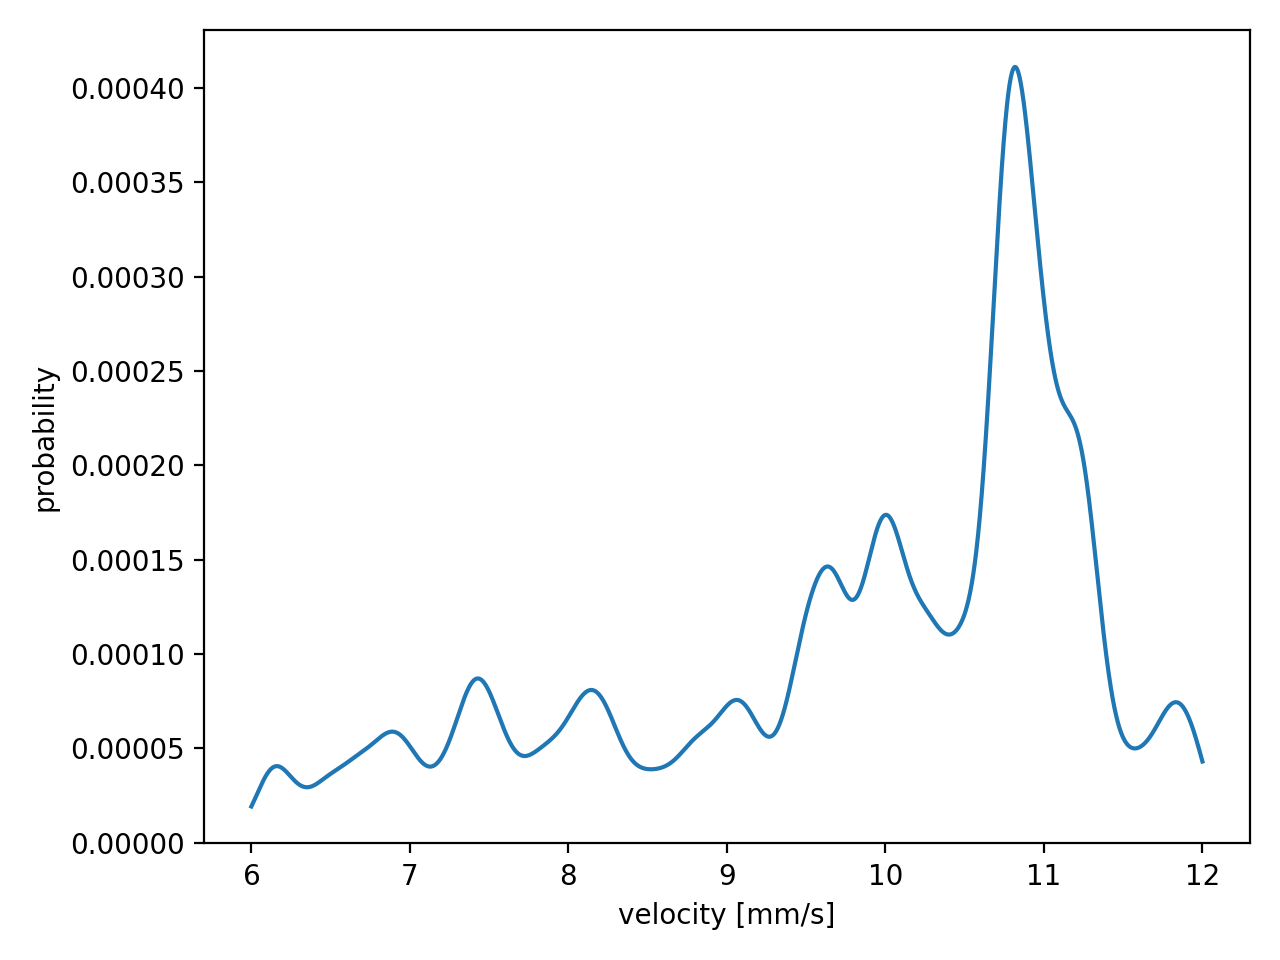

array([1.92251357e-05, 1.93289914e-05, 1.94331427e-05, ...,
       4.34178144e-05, 4.32332270e-05, 4.30486182e-05])

In [97]:
# kde plot

vs = np.linspace(6,12,10000)

kde_plot(vs, velocity_means, velocity_stds, min_sigma=0.1, xlabel='velocity [mm/s]')

<IPython.core.display.Javascript object>


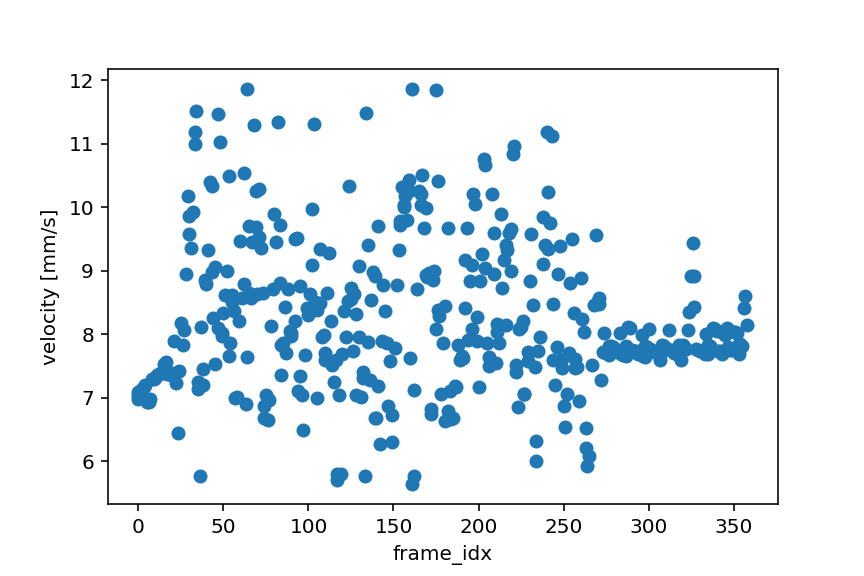

Text(0, 0.5, 'velocity [mm/s]')

In [166]:
# velocity - frame_id correlation

frames_idxs = [d.frames[-1] for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(frames_idxs, velocity_means)
plt.xlabel('frame_idx')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


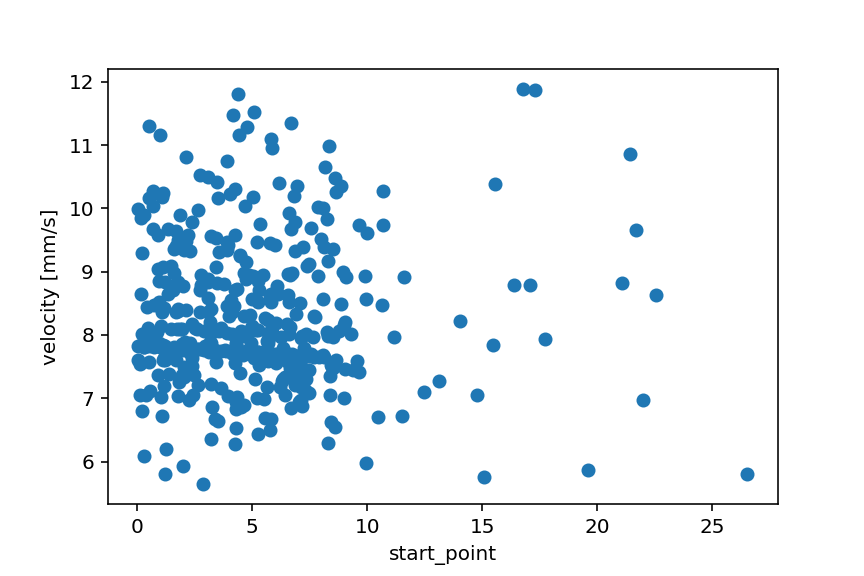

Text(0, 0.5, 'velocity [mm/s]')

In [135]:
# velocity - position correlation

starts= [d.starts[-1] for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(starts, velocity_means)
plt.xlabel('start_point')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


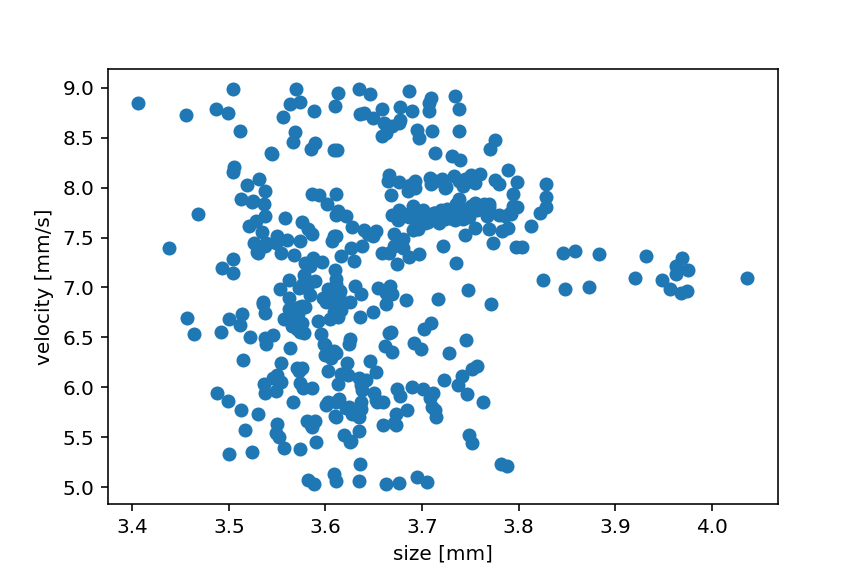

Text(0, 0.5, 'velocity [mm/s]')

In [52]:
# size - velocity correlation

plt.figure()
plt.scatter(size_means, velocity_means)
plt.xlabel('size [mm]')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


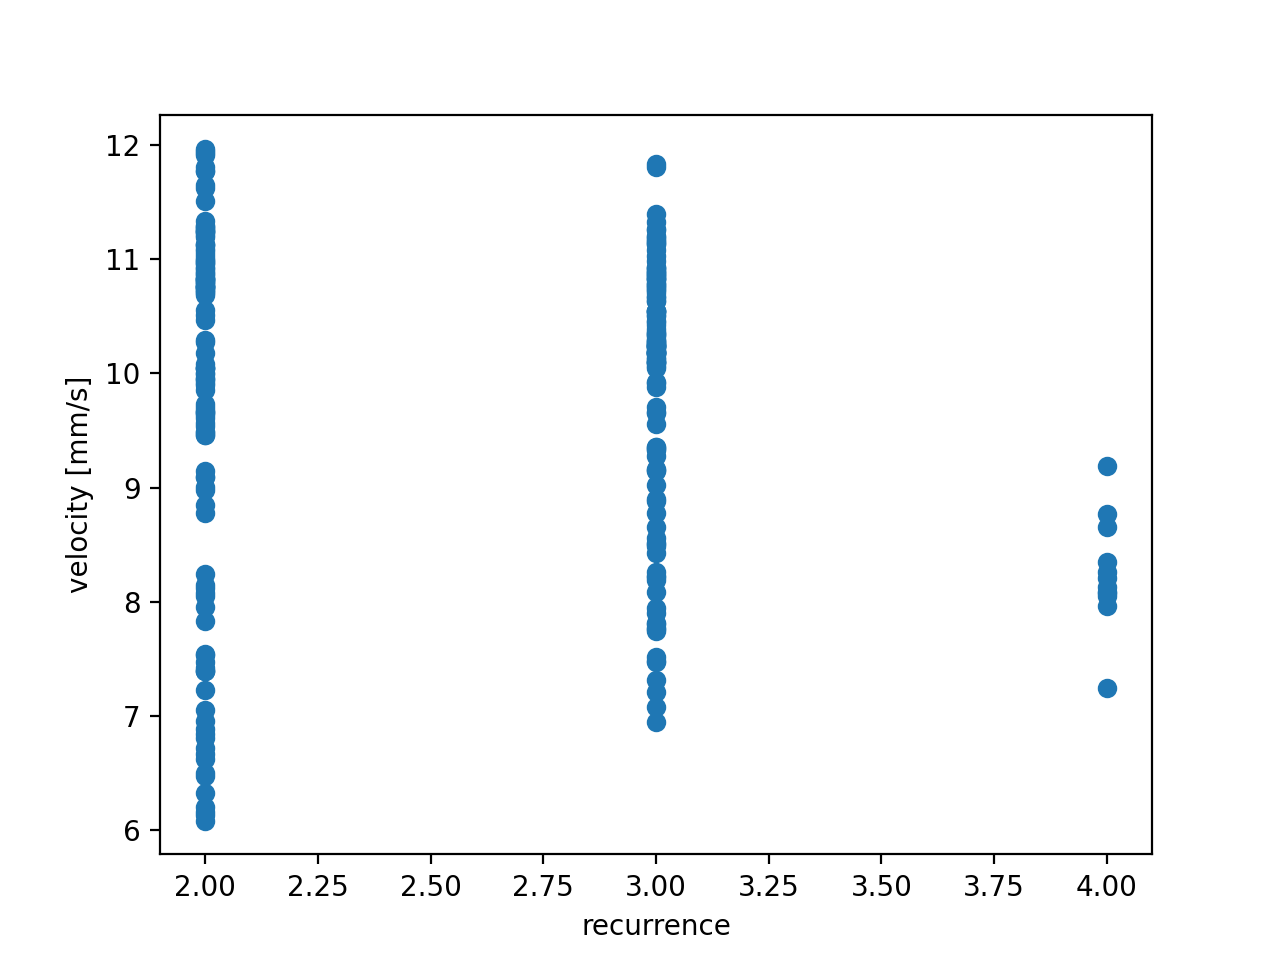

Text(0, 0.5, 'velocity [mm/s]')

In [118]:
# velocity - recurrence correlation

recurrences = [d.recurrence for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(recurrences, velocity_means)
plt.xlabel('recurrence')
plt.ylabel('velocity [mm/s]')